# Imports

In [1]:
# Essentials:
import io
import asyncio # for debounce
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

# UI:
from PIL import Image
import ipywidgets as widgets
from IPython.display import clear_output, HTML

# Neural Style Transfer (NST):
import tensorflow as tf
from keras import Model
from tensorflow import keras
from keras.layers import Conv2D
from keras.optimizers import SGD
from keras.utils import plot_model
from keras.models import Sequential
from keras.applications import vgg19

# Global Variables

In [2]:
# Variables defined by Keras guide https://keras.io/examples/generative/neural_style_transfer/
STYLE_WEIGHT = 1e-6
CONTENT_WEIGHT = 2.5e-8
TOTAL_VARIATION_WEIGHT = 1e-6
IMG_ROWS = 400
ITERATIONS = 4000

# VGG19 Model
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])
FEATURES = Model(inputs=model.inputs, outputs=outputs_dict)
STYLE_LAYERS = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
CONTENT_LAYER = "block5_conv2"
optimizer = SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

PAINTINGS = {"dots": "A Sunday Afternoon on the Island of La Grande Jatte by Georges Seurat", 
             "hat": "Woman with a Hat by Henri Matisse", 
             "monalisa": "The Mona Lisa by Leonardo Da Vinci", 
             "picasso": "Weeping Woman by Pablo Picasso", 
             "stars": "The Starry Night by Vincent Van Gogh", 
             "wave": "The Great Wave off Kanagawa by Hosukai"}

# Styling

In [3]:
# Centers output picture

HTML("""
    <style>
    .output_png {
        text-align: center;
    }
    </style>
""")

# Functions

### NST Functions

In [4]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [5]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = IMG_ROWS * img_cols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [6]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [7]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : IMG_ROWS - 1, : img_cols - 1, :] - x[:, 1:, : img_cols - 1, :]
    )
    b = tf.square(
        x[:, : IMG_ROWS - 1, : img_cols - 1, :] - x[:, : IMG_ROWS - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [8]:
def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combine all the images in the same tensor
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)

    # 2. Get the features of all the layers in all three images
    features = FEATURES(input_tensor)

    #3. Initialize the loss
    loss = tf.zeros(shape=())

    # 4. Add content loss
    layer_features = features[CONTENT_LAYER]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + CONTENT_WEIGHT * content_loss(base_image_features, combination_features)
    
    # 5. Add style loss
    for layer_name in STYLE_LAYERS:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (STYLE_WEIGHT / len(STYLE_LAYERS)) * sl
    
    # 6. Add total variation loss
    loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)
    
    return loss

In [9]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
        
    grads = tape.gradient(loss, combination_image)
    
    return loss, grads

In [10]:
def preprocess_image(image_path):

    if type(image_path) == str:
        img = keras.preprocessing.image.load_img(f"./data/{image_path}.jpg", target_size=(IMG_ROWS, img_cols))
    else:
        img = image_path.resize((img_cols, IMG_ROWS))
        
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)

    return tf.convert_to_tensor(img)

In [11]:
def deprocess_image(x):

    x = x.reshape((IMG_ROWS, img_cols, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype("uint8")

    return x

In [12]:
# Applies NST according to choice and displays it

def apply_nst(path):
    clear_output()
    show_buttons()
    
    print("***PLEASE DO NOT PRESS ANY OTHER BUTTON WHILE THIS RUNS***")
    
    base_image = preprocess_image(uploaded_base)
    style_image = preprocess_image(path)
    combination_image = tf.Variable(base_image)
    
    for i in tqdm(range(1, ITERATIONS + 1)):
        loss, grads = compute_loss_and_grads(combination_image, base_image, style_image)
        optimizer.apply_gradients([(grads, combination_image)])
        
    plt.figure(figsize=(16,6))
    plt.axis("off")
    
    if type(path) == str:
        plt.title(f"Restyled as {PAINTINGS[path]}", size=16)
    else:
        plt.title("Restyled with Custom Style")
        
#     if path in PAINTINGS:
#         plt.title(f"Restyled as {PAINTINGS[path]}", size=16)
#     else:
#         plt.title("Restyled with custom style")
        
    plt.imshow(deprocess_image(combination_image.numpy()));

### Debouncing Function

In [13]:
# From ipywidget to work with their widgets

class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def start(self):
        self._task = asyncio.ensure_future(self._job())

    def cancel(self):
        self._task.cancel()

def debounce(wait):
    def decorator(fn):
        timer = None
        def debounced(*args, **kwargs):
            nonlocal timer
            def call_it():
                fn(*args, **kwargs)
            if timer is not None:
                timer.cancel()
            timer = Timer(wait, call_it)
            timer.start()
        return debounced
    return decorator

### Event Functions

In [14]:
# Event handler for the color input field with debounce decorator

@debounce(0.8)
def custom_color_change(change):
    
    value = int(change["new"])
    
    if value < 1:
        recolor_image(1, "1 Color")
        
    elif value > 256:
        recolor_image(256, "256 Color")
        
    else:
        recolor_image(value, f"{value} Color")

    %rerun

In [15]:
# Event handler for uploaded base image

def base_image_upload_handler(value):
    
    # Getting the image uncompressed bytes object
    img_name = list(value)
    img_name = img_name[0]
    uploaded_img = value[img_name]["content"]

    # Converting the bytes into a compressed image
    uploaded_img = io.BytesIO(uploaded_img)
    uploaded_img = Image.open(uploaded_img)

    # Image properties
    uploaded_img_arr = np.asarray(uploaded_img)
    uploaded_height, uploaded_width, uploaded_colors = uploaded_img_arr.shape # strict order

    # Scaling the image on 256 colors
    data = uploaded_img_arr / 255.0
    data = data.reshape(uploaded_height * uploaded_width, uploaded_colors)

    return (uploaded_height, uploaded_width, uploaded_colors, uploaded_img, data)

In [16]:
# Event handler for uploaded style image

def style_image_upload_handler(value):
    
    # Getting the image uncompressed bytes object
    img_name = list(value.new)
    img_name = img_name[0]
    uploaded_style = value.new[img_name]["content"]

    # Converting the bytes into a compressed image
    uploaded_style = io.BytesIO(uploaded_style)
    uploaded_style = Image.open(uploaded_style)
    
    apply_nst(uploaded_style)

In [17]:
# Event handler for the buttons (on click)

def btn_eventhandler(obj):
    recolor_image(int(obj.tooltip), obj.description)

In [18]:
# Event handler for the original image button

def btn_eventhandler_og(obj):
    show_original()

In [19]:
# Event handler for the NST buttons

def nst_eventhandler(obj):
    apply_nst(obj.tooltip)

In [20]:
# Displays the recolor buttons

def show_recolor_button():
    # Laout for all the boxes
    box_layout = widgets.Layout(display='flex', flex_flow='row', justify_content="center")
    
    # Contents of recolor boxes
    color_buttons = [button_og, button_128, button_64, button_32, button_16, button_8, button_4, button_2]
    color_custom = [custom]
    
    # Recolor boxes
    box_colors = widgets.Box(children=color_buttons, layout=box_layout)
    box_colors_custom = widgets.Box(children=color_custom, layout=box_layout)
    
    # Stacking both HBoxes on top of each other
    box = widgets.VBox([box_colors, box_colors_custom])

    display(box)

In [21]:
# Displays the NST buttons

def show_NST_button():
    # Laout for all the boxes
    box_layout = widgets.Layout(display='flex', flex_flow='row', justify_content="center")
    
    # Contents of NST boxes
    nst_buttons = [button_dots, button_hat, button_mona, button_weeping, button_stars, button_wave]
    nst_custom = [custom_style_upload]
    
    # NST boxes
    box_nst = widgets.Box(children=nst_buttons, layout=box_layout)
    box_nst_custom = widgets.Box(children=nst_custom, layout=box_layout)
    
    # Stacking both HBoxes on top of each other
    box = widgets.VBox([box_nst, box_nst_custom])

    display(box)

In [22]:
def show_buttons():
    show_recolor_button()
    show_NST_button()

### Recoloring Functions

In [23]:
# Displays the original image

def show_original():
    clear_output()
    show_buttons()
    
    plt.figure(figsize=(16,6))
    plt.axis("off")
    plt.title("Original Image", size=16)
    plt.imshow(img);

In [24]:
# Color adjusting algorithm through Kmeans (1 picture)

def recolor_image(num_colors, title):
    clear_output()
    show_buttons()
    
    print("***PLEASE DO NOT PRESS ANY OTHER BUTTON WHILE THIS RUNS***")
    
    kmeans = MiniBatchKMeans(num_colors)
    kmeans.fit(data)
    
    new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

    uploaded_img_recolored = new_colors.reshape(uploaded_height, uploaded_width, uploaded_colors)
    
    plt.figure(figsize=(16,6))
    plt.axis("off")
    plt.title(f"{title} Image", size=16)
    plt.imshow(uploaded_img_recolored);

# Color Rescaling UI

### Recoloring Buttons

In [25]:
# Generating the buttons
button_og = widgets.Button(description="Original", tooltip="Original")
button_128 = widgets.Button(description="128 Color", tooltip="128")
button_64 = widgets.Button(description="64 Color", tooltip="64")
button_32 = widgets.Button(description="32 Color", tooltip="32")
button_16 = widgets.Button(description="16 Color", tooltip="16")
button_8 = widgets.Button(description="8 Color", tooltip="8")
button_4 = widgets.Button(description="4 Color", tooltip="4")
button_2 = widgets.Button(description="2 Color", tooltip="2")

# Setting the event handler on each button
button_og.on_click(btn_eventhandler_og)
button_128.on_click(btn_eventhandler)
button_64.on_click(btn_eventhandler)
button_32.on_click(btn_eventhandler)
button_16.on_click(btn_eventhandler)
button_8.on_click(btn_eventhandler)
button_4.on_click(btn_eventhandler)
button_2.on_click(btn_eventhandler)

### Custom Recolor Input

In [29]:
# Custom input field
custom = widgets.Text(placeholder='Number between 1 and 256', description = "Custom: ")

# Event handler
custom.observe(custom_color_change, "value")

### Neural Style Transfer Buttons

In [26]:
# Generating the buttons
button_dots = widgets.Button(description="A Sunday Afternoon", tooltip="dots")
button_hat = widgets.Button(description="Woman with a Hat", tooltip="hat")
button_mona = widgets.Button(description="Mona Lisa", tooltip="monalisa")
button_weeping = widgets.Button(description="Weeping Woman", tooltip="picasso")
button_stars = widgets.Button(description="Starry Night", tooltip="stars")
button_wave = widgets.Button(description="The Great Wave", tooltip="wave")

# Setting the event handler on each button
button_dots.on_click(nst_eventhandler)
button_hat.on_click(nst_eventhandler)
button_mona.on_click(nst_eventhandler)
button_weeping.on_click(nst_eventhandler)
button_stars.on_click(nst_eventhandler)
button_wave.on_click(nst_eventhandler)

### NST Custom Style Upload

In [30]:
custom_style_upload = widgets.FileUpload(accept="image/*", multiple=False, description="Custom Style")

custom_style_upload.observe(style_image_upload_handler, "value")

# Interface

### Upload Button

In [31]:
# Upload Button
base_image_uploader = widgets.FileUpload(accept="image/*", multiple=False)
print("Upload your base image (will be styled)")
display(base_image_uploader)

Upload your base image (will be styled)


FileUpload(value={}, accept='image/*', description='Upload')

### Converting the uploaded image into data

In [34]:
uploaded_height, uploaded_width, uploaded_colors, uploaded_base, data = base_image_upload_handler(base_image_uploader.value)
img_cols = int(uploaded_width * IMG_ROWS / uploaded_height)

  0%|          | 0/4000 [00:00<?, ?it/s]

***PLEASE DO NOT PRESS ANY OTHER BUTTON WHILE THIS RUNS***


100%|██████████| 4000/4000 [13:14<00:00,  5.04it/s]


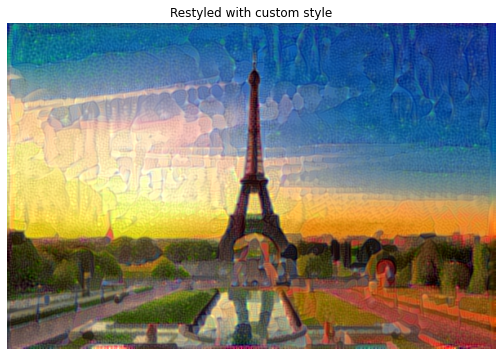

In [35]:
show_buttons()

In [ ]:
# # Displays the buttons

# def show_buttons():
    
#     # Laout for all the boxes
#     box_layout = widgets.Layout(display='flex', flex_flow='row', justify_content="center")

#     # Contents of recolor boxes
#     color_buttons = [button_og, button_128, button_64, button_32, button_16, button_8, button_4, button_2]
#     color_custom = [custom]
    
#     # Contents of NST boxes
#     nst_buttons = [button_dots, button_hat, button_mona, button_weeping, button_stars, button_wave]
# #     nst_custom = ["Custom style: ", "UPLOAD BUTTON"]

#     # Recolor boxes
#     box_colors = widgets.Box(children=color_buttons, layout=box_layout)
#     box_colors_custom = widgets.Box(children=color_custom, layout=box_layout)
    
#     # NST boxes
#     box_nst = widgets.Box(children=nst_buttons, layout=box_layout)
# #     box_nst_custom = widgets.Box(children=nst_custom, layout=box_layout)
    
#     # Final box (stacking all 4 on top of each other)
#     box = widgets.VBox([box_colors, box_colors_custom, box_nst])
    
#     display(box)

In [ ]:
# # Color adjusting algorithm through Kmeans (side by side)

# def generate_images(num_colors, title):
#     clear_output()
#     show_buttons()
    
#     kmeans = MiniBatchKMeans(num_colors)
#     kmeans.fit(data)
    
#     new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

#     img_recolored = new_colors.reshape(height, width, colors)

#     fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
#     fig.subplots_adjust(wspace=0.05)
    
#     ax[0].imshow(img)
#     ax[0].set_title('Original Image', size=16)
#     ax[1].imshow(img_recolored)
#     ax[1].set_title(f'{title}', size=16);